In [1]:
import torch.nn as nn
import torch
import os
import sys
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.optim as optim

sys.path.append('../')
from utils import BrainGraphDataset, project_root, get_data_labels

dataroot = 'fc_matrices/psilo_schaefer_after/'
annotations = 'annotations.csv'

categories = ['patient_n','condition','bdi_before']

data_labels = get_data_labels()
data_labels = data_labels[categories]

data_labels.loc[data_labels["condition"] == "P", "condition"] = 1
data_labels.loc[data_labels["condition"] == "E", "condition"] = -1
data_labels['condition'] = data_labels['condition'].astype('float64')

parent_dir = project_root()
dataset = BrainGraphDataset(img_dir=os.path.join(parent_dir, dataroot),
                            annotations_file= os.path.join(parent_dir, annotations),
                            transform=None, extra_data=data_labels, setting='upper_triangular_and_baseline')

loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

In [2]:
import torch

(_, base), labels = next(iter(loader))

labels = labels.float()
mu = torch.mean(labels)
std = torch.std(labels)
median = torch.median(labels)
q1 = torch.quantile(labels, 0.25)
q3 = torch.quantile(labels, 0.75)

print(f'Mean is {mu}')
print(f'Standard deviation is {std}')
print(f'Median is {median}')
print(f'First quartile (Q1) is {q1}')
print(f'Third quartile (Q3) is {q3}')




Mean is 12.357142448425293
Standard deviation is 10.120786666870117
Median is 10.0
First quartile (Q1) is 4.0
Third quartile (Q3) is 16.5


In [3]:
import numpy as np

(_, base), labels = next(iter(loader))

base = np.array(base.tolist())
labels = np.array(labels.tolist())

psilo_indices = np.where(base[:, 0] == 1)
esc_indices = np.where(base[:, 0] == -1)
    
psilo_pre_bdi = base[:, 1][psilo_indices]
psilo_post_bdi = labels[psilo_indices]
psilo_diff = psilo_post_bdi - psilo_pre_bdi

psilo_decrease = np.count_nonzero(psilo_diff <= 0)
psilo_increase = np.count_nonzero(psilo_diff > 0)

print(psilo_decrease)
print(psilo_increase)


esc_pre_bdi = base[:, 1][esc_indices]
esc_post_bdi = labels[esc_indices]
esc_diff = esc_post_bdi - esc_pre_bdi

esc_decrease = np.count_nonzero(esc_diff <= 0)
esc_increase = np.count_nonzero(esc_diff > 0)

print(esc_decrease)
print(esc_increase)



21
1
16
4


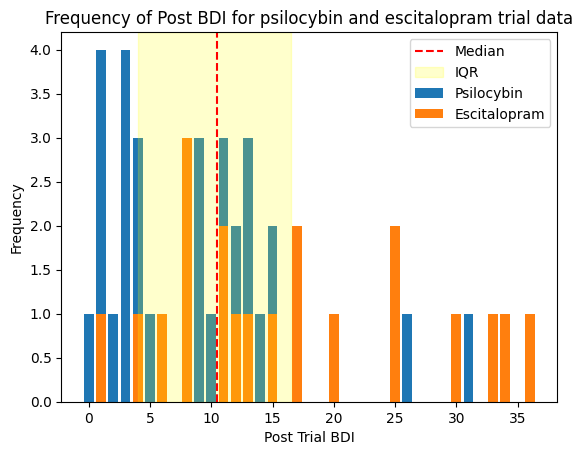

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the frequency of each unique label for psilo_post_bdi
psilo_unique_labels, psilo_label_counts = np.unique(psilo_post_bdi, return_counts=True)

# Calculate the frequency of each unique label for esc_post_bdi
esc_unique_labels, esc_label_counts = np.unique(esc_post_bdi, return_counts=True)

for f in esc_unique_labels:
    if f in psilo_unique_labels:
        j = np.where(psilo_unique_labels==f)[0]
        psilo_label_counts[j] += esc_label_counts[j]

# Create a bar chart for psilo_post_bdi
plt.bar(psilo_unique_labels, psilo_label_counts, label='Psilocybin')

# Create a stacked bar chart for esc_post_bdi on top of psilo_post_bdi
plt.bar(esc_unique_labels, esc_label_counts, label='Escitalopram')

# Set y-axis label
plt.ylabel('Frequency')

plt.xlabel('Post Trial BDI')

# Set title
plt.title('Frequency of Post BDI for psilocybin and escitalopram trial data')

# Set x-axis ticks and labels based on unique labels
plt.xticks(np.arange(min(min(psilo_unique_labels), min(esc_unique_labels)), max(max(psilo_unique_labels), max(esc_unique_labels)) + 1))

# Calculate median and interquartile range (IQR)
median = np.median(labels)
q1 = np.percentile(labels, 25)
q3 = np.percentile(labels, 75)

# Mark median and IQR on the bar chart
plt.axvline(x=median, color='red', linestyle='--', label='Median')
plt.axvspan(q1, q3, color='yellow', alpha=0.2, label='IQR')

# Set x-axis ticks and labels based on unique labels
plt.xticks(np.arange(0, 40, 5))

# Show legend
plt.legend()

# Save the plot
plt.savefig('psilo_esc_frequency_plot.png', bbox_inches='tight')

# Show the plot
plt.show()


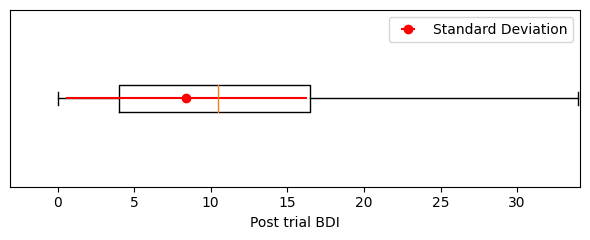

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already loaded and preprocessed the data into a list or array called 'data'
# 'data' should contain the values you want to visualize in the box plot

# Compute the mean and standard deviation of the data
mean_val = np.mean(psilo_post_bdi)
std_val = np.std(psilo_post_bdi)

# Create the figure and axes
fig, ax = plt.subplots(figsize=(6, 2.5))

# Create the box plot
ax.boxplot(labels, vert=False)

ax.set_yticks([])
# Set the title and labels
ax.set_xlabel("Post trial BDI")

# Show the appropriate range on the x-axis
min_val = min(psilo_post_bdi)
max_val = max(psilo_post_bdi)
ax.set_xlim([min_val - 0.1*(max_val-min_val), max_val + 0.1*(max_val-min_val)])

# Add error bars representing the standard deviation
ax.errorbar(mean_val, 1, xerr=std_val, fmt='o', color='red', label='Standard Deviation')

fig.tight_layout()

# Display the plot
plt.legend()
plt.savefig('after_bdi_box_plot_treatment.png')
plt.show()

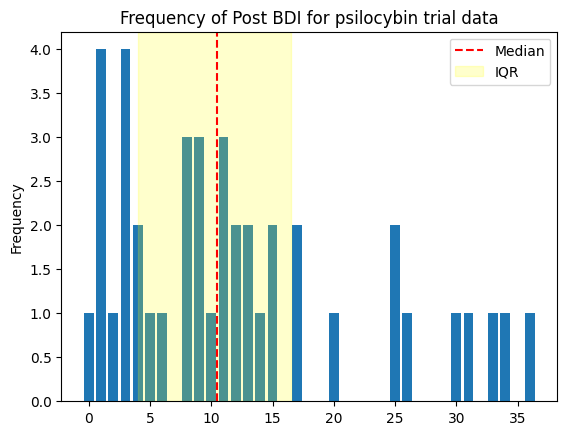

In [20]:
import matplotlib.pyplot as plt
import numpy as np

_, labels = next(iter(loader))

labels = labels.numpy()

# Calculate the frequency of each unique label
unique_labels, label_counts = np.unique(labels, return_counts=True)

# Create a bar chart
plt.bar(unique_labels, label_counts)

# Set y-axis label
plt.ylabel('Frequency')

# Set title
plt.title('Frequency of Post BDI for psilocybin trial data')

# Set x-axis ticks and labels based on unique labels
plt.xticks(np.arange(0, max(unique_labels), 5))

# Calculate median and interquartile range (IQR)
median = np.median(labels)
q1 = np.percentile(labels, 25)
q3 = np.percentile(labels, 75)

# Mark median and IQR on the bar chart
plt.axvline(x=median, color='red', linestyle='--', label='Median')
plt.axvspan(q1, q3, color='yellow', alpha=0.2, label='IQR')

# Show legend
plt.legend()
plt.savefig('frequency_plot.png', bbox_inches='tight')
# Show the plot
plt.show()


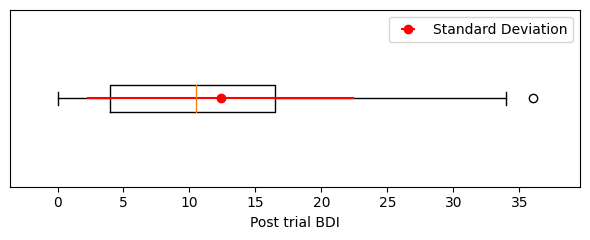

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already loaded and preprocessed the data into a list or array called 'data'
# 'data' should contain the values you want to visualize in the box plot

# Compute the mean and standard deviation of the data
mean_val = torch.mean(labels)
std_val = torch.std(labels)

# Create the figure and axes
fig, ax = plt.subplots(figsize=(6, 2.5))

# Create the box plot
ax.boxplot(labels, vert=False)

ax.set_yticks([])
# Set the title and labels
ax.set_xlabel("Post trial BDI")

# Show the appropriate range on the x-axis
min_val = min(labels)
max_val = max(labels)
ax.set_xlim([min_val - 0.1*(max_val-min_val), max_val + 0.1*(max_val-min_val)])

# Add error bars representing the standard deviation
ax.errorbar(mean_val, 1, xerr=std_val, fmt='o', color='red', label='Standard Deviation')

fig.tight_layout()

# Display the plot
plt.legend()
plt.savefig('after_bdi_box_plot.png')
plt.show()
